In [1]:
import sys
import numpy as np
from scipy import constants,linalg
from numba import jit, njit, prange, set_num_threads
import time
from matplotlib import pyplot as plt

set_num_threads(8)
np.set_printoptions(threshold=sys.maxsize)

Construct the potential matrix with the state of h,k,l,
h = -H,-H+1,...,-1,0,1,...,H-1,H
k = -K,-K+1,...,-1,0,1,...,K-1,K
l = -L,-L+1,...,-1,0,1,...,L-1,L
First constuct a symmetry matrix by pseudmatrix()
pseudomatrix will generate a P matrix with size ((2H+1)*(2K+1)*(2L+1))*((2H+1)*(2K+1)*(2L+1)) in a folloing form
[[[-H,-K,-L],[-H,-K,-L],...,[-H,-K,-L]],
[[-H,-K,-L+1],[-H,-K,-L+1],...,[-H,-K,-L+1]],
...
[[H-1,K,L],[H-1,K,L],...,[H-1,K,L]],
[[H,K,L],[H,K,L],...,[H,K,L]]]
P = P.transpose()-P 
Which P become the states of h,k,l matrix
the potential is the form $\frac{Coeff}{|G_i-G_j|}$ wiich equal to $\frac{Coeff}{|h^2+k^2+l^2}{\frac{2\pi}{a}}^2$
then we can generate potential matrix from P by useing result_matrix()


In [2]:
def potential_matrix(H,K,L,coefficient,reciprocal_basis):
    n=(2*H+1)*(2*K+1)*(2*L+1)
    pseudomatrix=pseudomatrix_kernal(H,K,L,n)
    pseudomatrix=pseudomatrix.transpose((1,0,2))-pseudomatrix
    result_matrix = result_matrix_kernal(pseudomatrix,H,K,L,n,reciprocal_basis)
    return result_matrix*coefficient


def potential_coefficient(a,parameter):
    return -parameter*(constants.elementary_charge)**2/(a*constants.pi*constants.epsilon_0)

In [3]:
@njit(parallel=True)
def pseudomatrix_kernal(H,K,L,n):
    pseudomatrix = np.zeros((n,n,3))
    for h in prange(-H,H+1):
        for k in prange(-K,K+1):
            for l in prange(-L,L+1):
                for j in prange(n):
                    pseudomatrix[(h+H)*((2*K+1)*(2*L+1))+(k+K)*(2*L+1)+(l+L),j]=np.array([h,k,l])
    return pseudomatrix

In [4]:
test_size = 7
pseudomatrix_test = pseudomatrix_kernal(test_size,test_size,test_size,(2*test_size+1)**3)
print((pseudomatrix_test.transpose((1,0,2)))[:3,:3])
print((pseudomatrix_test)[:3,:3])
print((pseudomatrix_test.transpose((1,0,2))-pseudomatrix_test)[:6,:6]**2)

[[[-7. -7. -7.]
  [-7. -7. -6.]
  [-7. -7. -5.]]

 [[-7. -7. -7.]
  [-7. -7. -6.]
  [-7. -7. -5.]]

 [[-7. -7. -7.]
  [-7. -7. -6.]
  [-7. -7. -5.]]]
[[[-7. -7. -7.]
  [-7. -7. -7.]
  [-7. -7. -7.]]

 [[-7. -7. -6.]
  [-7. -7. -6.]
  [-7. -7. -6.]]

 [[-7. -7. -5.]
  [-7. -7. -5.]
  [-7. -7. -5.]]]
[[[ 0.  0.  0.]
  [ 0.  0.  1.]
  [ 0.  0.  4.]
  [ 0.  0.  9.]
  [ 0.  0. 16.]
  [ 0.  0. 25.]]

 [[ 0.  0.  1.]
  [ 0.  0.  0.]
  [ 0.  0.  1.]
  [ 0.  0.  4.]
  [ 0.  0.  9.]
  [ 0.  0. 16.]]

 [[ 0.  0.  4.]
  [ 0.  0.  1.]
  [ 0.  0.  0.]
  [ 0.  0.  1.]
  [ 0.  0.  4.]
  [ 0.  0.  9.]]

 [[ 0.  0.  9.]
  [ 0.  0.  4.]
  [ 0.  0.  1.]
  [ 0.  0.  0.]
  [ 0.  0.  1.]
  [ 0.  0.  4.]]

 [[ 0.  0. 16.]
  [ 0.  0.  9.]
  [ 0.  0.  4.]
  [ 0.  0.  1.]
  [ 0.  0.  0.]
  [ 0.  0.  1.]]

 [[ 0.  0. 25.]
  [ 0.  0. 16.]
  [ 0.  0.  9.]
  [ 0.  0.  4.]
  [ 0.  0.  1.]
  [ 0.  0.  0.]]]


In [5]:
@njit(parallel=True)
def result_matrix_kernal(pseudomatrix,H,K,L,n,reciprocal_basis):
    result_matrix = np.zeros((n,n))
    for h in prange(-H,H+1):
        for k in prange(-K,K+1):
            for l in prange(-L,L+1):
                index = (h+H)*((2*K+1)*(2*L+1))+(k+K)*(2*L+1)+(l+L)
                for j in prange(n):
                    if j!=index:
                        result_matrix[index,j]=1/np.sum((pseudomatrix[index][j]*reciprocal_basis)**2)
    return result_matrix

H = $E_k$ + U
here we need to construct $E_k$ = $\frac{\hbar^2}{2m}({|k-G|}^2-{|k|}^2)$

In [6]:
@njit(parallel=True)
def halmitonian_kernal(k_vector,H,K,L,reciprocal_basis,n):
    halmitonian_matrix = np.zeros((n,n))
    for h in prange(-H,H+1):
        for k in prange(-K,K+1):
            for l in prange(-L,L+1):
                index = (h+H)*((2*K+1)*(2*L+1))+(k+K)*(2*L+1)+(l+L)
                halmitonian_matrix[index,index]=np.sum((k_vector-(h*reciprocal_basis[0]+k*reciprocal_basis[1]+l*reciprocal_basis[2]))**2)
    return halmitonian_matrix

def halmitonian(potential_matrix,k_vertor,H,K,L,reciprocal_basis):
    n=(2*H+1)*(2*K+1)*(2*L+1)
    halmitonian_matrix = halmitonian_kernal(k_vertor,H,K,L,reciprocal_basis,n)
    return halmitonian_matrix+potential_matrix

In [7]:
def states(N):
    num = np.floor(np.power(N,1.0/3))
    H = num//2
    K = num//2
    L = np.floor(N/((2*H+1)*(2*K+1))//2)
    return int(H),int(K),int(L)


def path_initialize(k_start,k_end,N=50):
    N = int(N)
    k_1 = np.linspace(k_start[0],k_end[0],endpoint=True,num=N)
    k_2 = np.linspace(k_start[1],k_end[1],endpoint=True,num=N)
    k_3 = np.linspace(k_start[2],k_end[2],endpoint=True,num=N)
    return np.array([k_1,k_2,k_3])


In [8]:
def band_structure(H,K,L,radius,parameter,reciprocal_basis,Path):
    start = time.time()
    potentialmatrix=potential_matrix(H,K,L,potential_coefficient(radius, parameter),reciprocal_basis)
    end = time.time()
    E_0 = constants.hbar**2*(2*constants.pi)**2/(2*radius**2*constants.electron_mass)
    potentialmatrix/=E_0
    print(f"Potential matrix calculation done in {end-start:.2f} seconds")
    bands = []
    for path in Path:
        for i in np.arange(len(path[0])):
            start = time.time()
            Ham = halmitonian(potentialmatrix,np.array([path[0][i],path[1][i],path[2][i]]),H,K,L,reciprocal_basis)
            end = time.time()
            print(f"Hamiltonian calculation done in {end-start:.2f} seconds")
            start = time.time()
            eigen_value= linalg.eigvalsh(Ham)
            end = time.time()
            print(f"Eigenvalue calculation done in {end-start:.2f} seconds")
            bands.append(np.sort(eigen_value.real)*E_0)
            print(i)
            print(f"Processed k-point {i+1}/{len(path[0])}")
    return np.stack(bands, axis=-1)

In [9]:
RECIPROCAL_BASIS = np.array([
        [-1, 1, 1],
        [1, -1, 1],
        [1, 1, -1]
])

# sample points per k-path
n = 100

# symmetry points in the Brillouin zone
G = np.array([0, 0, 0])
L = np.array([1/2, 1/2, 1/2])
K = np.array([3/4, 3/4, 0])
X = np.array([0, 0, 1])
W = np.array([1, 1/2, 0])
U = np.array([1/4, 1/4, 1])

# k-paths
lambd = path_initialize(L, G, n)
delta = path_initialize(G, X, n)
x_uk = path_initialize(X, U, n / 4)
sigma = path_initialize(K, G, n)

H,K,L=7,7,7

In [10]:
SIMPLE_CUBIC = np.array([[1,0,0],[0,1,0],[0,0,1]])

GG = np.array([0,0,0])
XX = np.array([0,0.5,0])
MM = np.array([0.5,0.5,0])
RR = np.array([0.5,0.5,0.5])

GX = path_initialize(GG,XX,50)
XM = path_initialize(XX,MM,50)
MR = path_initialize(MM,RR,50)
RG = path_initialize(RR,GG,50)

In [11]:
BCC = np.array([[0,1,1],[1,0,1],[1,1,0]])
G = np.array([0,0,0])
H = np.array([0,0,1])
P = np.array([0.5,0.5,0.5])
N = np.array([0.5,0.5,0])

kpath = 50
GH = path_initialize(G,H,kpath)
HP = path_initialize(H,P,kpath)
PG = path_initialize(P,G,kpath)
GN = path_initialize(G,N,kpath)
NH = path_initialize(N,H,kpath)
# sodium_band = band_structure(4,4,4,4.29*1e-10,0.0365,BCC,[GH,HP,PG,GN,NH])
# sodium_band = band_structure(3,3,3,4.29*1e-10,0.031,BCC,[GH,HP,PG,GN,NH])
sodium_band = band_structure(4,4,4,3.65*1e-10,0.031,BCC,[GH,HP,PG,GN,NH])

Potential matrix calculation done in 0.65 seconds
Hamiltonian calculation done in 0.43 seconds
Eigenvalue calculation done in 0.07 seconds
0
Processed k-point 1/50
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.07 seconds
1
Processed k-point 2/50
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.07 seconds
2
Processed k-point 3/50
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.07 seconds
3
Processed k-point 4/50
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.07 seconds
4
Processed k-point 5/50
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.07 seconds
5
Processed k-point 6/50
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.07 seconds
6
Processed k-point 7/50
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.07 seconds
7
Processed k-point 8/50
Hamiltonian calculation done in 0.00 s

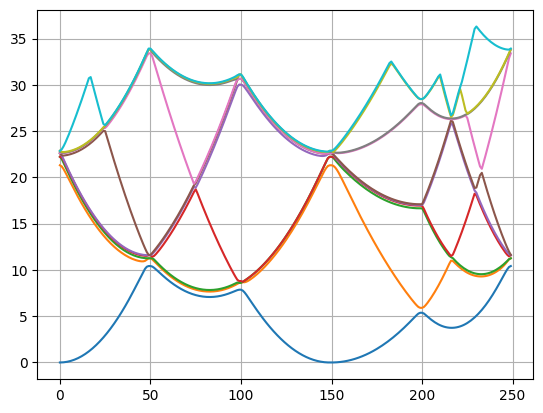

In [12]:
for i in sodium_band[:10]:
    plt.plot(i/constants.electron_volt)
plt.grid(which='both')

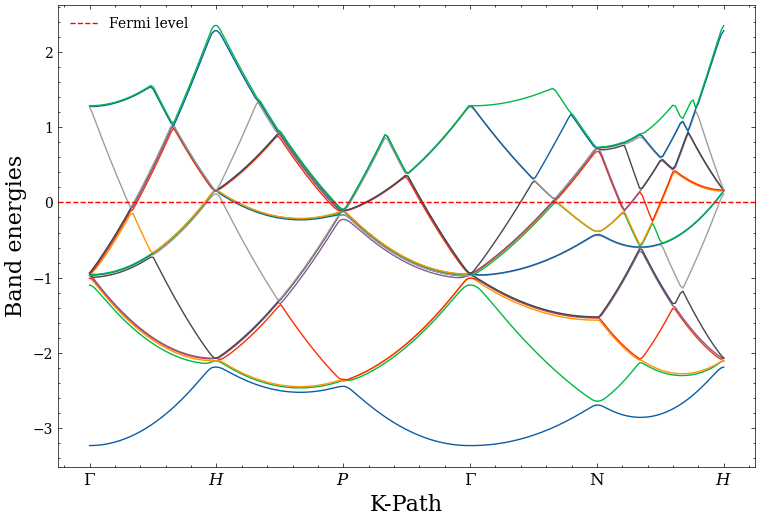

In [13]:
# use plot_theme.mplstyle to set plot theme
plt.style.use('../tight_binding/bandstructure/plot_theme.mplstyle')
fig, ax = plt.subplots()
total_path = kpath*5
x = np.linspace(0, total_path, total_path, endpoint=True)
for i in sodium_band[:16]:
    # fermi level of sodium 3.23 eV
    plt.plot(x, i/constants.electron_volt/10-3.23)

plt.axhline(y = 0, color = 'r', linestyle = '--', label='Fermi level') 
plt.legend()
# customizing plot
xticks = [0, total_path/5, 2*total_path/5, 3*total_path/5, 4*total_path/5, total_path]
ax.set_xticks(xticks, [r'$\Gamma$', '$H$', '$P$', r'$\Gamma$', 'N', '$H$'])
ax.set_xlabel('K-Path')
ax.set_ylabel('Band energies')
plt.show()

**Silicon**

In [14]:
DIAMOND = np.array([[-1,1,1],[1,-1,1],[1,1,-1]])
G = np.array([0, 0, 0])
K = np.array([3/4, 3/4, 0])
L = np.array([1/2, 1/2, 1/2])
U = np.array([1/4, 1/4, 1])
W = np.array([1, 1/2, 0])
X = np.array([0, 0, 1])

kpath = 100
lambd = path_initialize(L,G,kpath)
delta =path_initialize(G,X,kpath)
x_uk = path_initialize(X,U,kpath)
sigma = path_initialize(K,G,kpath)

sodium_band = band_structure(4,4,4,5.43e-10,0.031,DIAMOND,[lambd,delta,x_uk,sigma])

Potential matrix calculation done in 0.02 seconds
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.07 seconds
0
Processed k-point 1/100
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.07 seconds
1
Processed k-point 2/100
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.06 seconds
2
Processed k-point 3/100
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.07 seconds
3
Processed k-point 4/100
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.07 seconds
4
Processed k-point 5/100
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.07 seconds
5
Processed k-point 6/100
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.13 seconds
6
Processed k-point 7/100
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.08 seconds
7
Processed k-point 8/100
Hamiltonian calculation done i

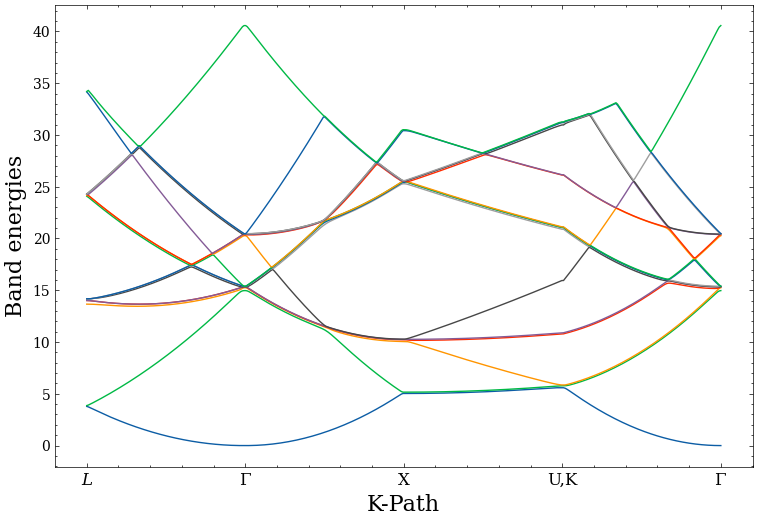

In [ ]:
# use plot_theme.mplstyle to set plot theme
plt.style.use('../tight_binding/bandstructure/plot_theme.mplstyle')
fig, ax = plt.subplots()
total_path = kpath*4
x = np.linspace(0, total_path, total_path, endpoint=True)
for i in sodium_band[:16]:
    plt.plot(x, i/constants.electron_volt)
# customizing plot
xticks = [0, total_path/4, 2*total_path/4, 3*total_path/4, total_path]

ax.set_xticks(xticks, ['$L$', '$\Gamma$', 'X', 'U,K', '$\Gamma$'])
ax.set_xlabel('K-Path')
ax.set_ylabel('Band energies')
plt.show()

**cubic**

In [ ]:
SIMPLE_CUBIC = np.array([[1,0,0],[0,1,0],[0,0,1]])

GG = np.array([0,0,0])
XX = np.array([0,0.5,0])
MM = np.array([0.5,0.5,0])
RR = np.array([0.5,0.5,0.5])

GG = np.array([-1,0,0])
XX = np.array([-0.5,0,0])
MM = np.array([0,0,0])
RR = np.array([0.5,0,0])
ZZ = np.array([1,0,0])

kpath = 100
GX = path_initialize(GG,XX,kpath)
XM = path_initialize(XX,MM,kpath)
MR = path_initialize(MM,RR,kpath)
RG = path_initialize(RR,GG,kpath)
RG = path_initialize(RR,ZZ,kpath)

bands_simple = band_structure(4,4,4,1e-10,0,SIMPLE_CUBIC,[GX,XM,MR,RG])

Potential matrix calculation done in 0.02 seconds
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.07 seconds
0
Processed k-point 1/100
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.07 seconds
1
Processed k-point 2/100
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.05 seconds
2
Processed k-point 3/100
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.06 seconds
3
Processed k-point 4/100
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.06 seconds
4
Processed k-point 5/100
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.06 seconds
5
Processed k-point 6/100
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.06 seconds
6
Processed k-point 7/100
Hamiltonian calculation done in 0.00 seconds
Eigenvalue calculation done in 0.10 seconds
7
Processed k-point 8/100
Hamiltonian calculation done i

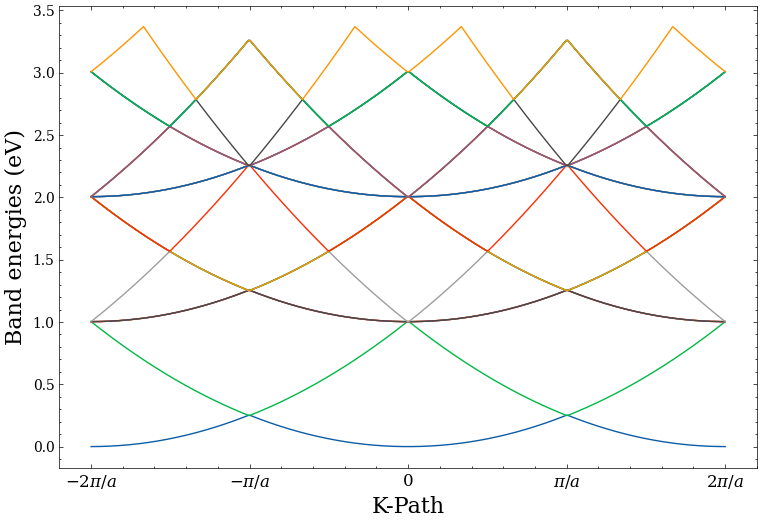

In [ ]:
# use plot_theme.mplstyle to set plot theme
plt.style.use('../tight_binding/bandstructure/plot_theme.mplstyle')
fig, ax = plt.subplots()
total_path = kpath*4
x = np.linspace(0, total_path, total_path, endpoint=True)
for i in bands_simple[:24]:
    plt.plot(x, i/constants.electron_volt/150)
# customizing plot
xticks = [0, total_path/4, 2*total_path/4, 3*total_path/4, total_path]

ax.set_xticks(xticks, ['$\Gamma$', '$X$', 'M', 'R', '$\Gamma$'])
ax.set_xticks(xticks, [r'$-2\pi/a$', r'$-\pi/a$', '0', r'$\pi/a$', r'$2\pi/a$'])
ax.set_xlabel('K-Path')
ax.set_ylabel('Band energies (eV)')
plt.show()